# Graph Data Science for Supply Chain
## Using Shortest Path for Route Optimization
![Neo4j version](https://img.shields.io/badge/Neo4j->=4.4.9-brightgreen)
![GDS version](https://img.shields.io/badge/GDS->=2.2-brightgreen)

This notebook demonstrates how [Neo4j Graph Data Science](https://neo4j.com/docs/graph-data-science/current/algorithms/) can be applied to supply chain data to: find new, faster, paths through supply chain processes.

We will start with a brief overview of the dataset we'll be using.  After that we will explore how path finding can identify new and faster shipment routes, walking through a specific example that reveals potential to improve performance by up to 40%.

It is worth noting that while we are using an air cargo freight forwarding dataset in this example, the same techniques can be applied to other types of logistics, including maritime and trucking services as well as other types of supply chain domains including manufacturing, inventory management, and bill of materials.

## Prerequisites
- The Cargo 2000 case study dataset must be loaded into Neo4j. You can do so by running [this notebook](https://github.com/neo4j-product-examples/ds-supply-chain-use-cases/blob/main/modeling-eda-visualization-c2k/transform-and-load.ipynb). It should take no more than a few minutes to complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ds_utils
from graphdatascience import GraphDataScience

In [2]:
# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience('neo4j://localhost', auth=('neo4j', 'examplePassword'))

## Dataset

For a sample dataset we will use the “Cargo 2000” transport and logistics case study [[1]](#1). Cargo 2000 (re-branded as Cargo iQ in 2016) is an initiative of the International Air Transport Association (IATA) that aims to deliver a new quality management system for the air cargo industry.

The below figure shows a model of the business processes covered in the IATA case study. It represents the business processes of a freight forwarding company, in which up to three smaller shipments from suppliers are consolidated and then shipped together to customers. The business process is structured into incoming and outgoing transport legs, with the overall objective that freight is delivered to customers in a timely manner.  You can find out more about the business model in [this blog](https://neo4j.com/developer-blog/supply-chain-neo4j-gds-bloom/) where we explored the dataset in Neo4j Bloom or from the [original data source]( https://s-cube-network.eu/c2k/).

<img src="img/logistics-diagram.png" alt="summary" width="1000"/>

## References
<a id="1">[1]</a> A. Metzger, P. Leitner, D. Ivanovic, E. Schmieders, R. Franklin, M. Carro, S. Dustdar, and K. Pohl, “ Comparing and combining predictive business process monitoring techniques,” IEEE Trans. on Systems Man Cybernetics: Systems, 2015.

## Understanding Historic Shipment Routes
We transform the above data into the graph data model depicted below.

<img src="img/c2k-schema.png" alt="summary" width="1000"/>


Individual shipments consist of one or multiple incoming legs that merge into a single outgoing leg for delivery.  Each leg, incoming and outgoing, has the potential for multiple connecting flights.  For reference, below is an example of what a single shipment looks like in the graph with three incoming legs originating from Davidburgh, Paulchester, and Moodytown, and outgoing leg going to Davisfort.


<img src="img/paths-of-single-shipments.png" alt="summary" width="1000"/>

With this data model we can pull the total effective minutes for historic shipments paths with Cypher. A path being the set of nodes and relationships that track a single incoming leg end-to-end, going from the source airport EntryPoint all the way to the target airport Destination in a shipment. Below is a table and distribution of total time for paths going from Moodytown to Davisfort, one of the most frequent paths in the logistic network.

In [3]:
# Calculate distribution for a single path
source_airport_id = 815 #'Moodytown'
target_airport_id = 700 #'Davisfort'
moodytown_davisfort_df = gds.run_cypher('''
    //match incoming legIds (leg numbers are > 0)
    MATCH(:EntryPoint {airportId: $sourceAirportId})-[r:RECEPTION]->() WHERE r.legNumber > 0
    WITH r.legId AS incomingLegId, r.shipmentId AS shipmentId
    //filter to only shipmentIds that go to target airport
    MATCH()-[:DELIVERY {shipmentId:shipmentId}]->(:Destination {airportId: $targetAirportId})
    WITH incomingLegId, shipmentId
    //incoming relationships
    MATCH()-[r {legId: incomingLegId}]->()
    WITH incomingLegId, shipmentId, sum(r.effectiveMinutes) AS incomingMinutes
    //outgoing relationships (leg numbers are < 0)
    MATCH()-[r {shipmentId: shipmentId}]->() WHERE r.legNumber < 0
    WITH incomingLegId, r.legId AS outgoingLegId, shipmentId, incomingMinutes, sum(r.effectiveMinutes) AS outgoingMinutes
    //sum all results on return
    RETURN incomingLegId, outgoingLegId, shipmentId, incomingMinutes, outgoingMinutes, (incomingMinutes + outgoingMinutes) AS totalMinutes
    ORDER BY incomingLegId
''', params = {'sourceAirportId': source_airport_id, 'targetAirportId': target_airport_id})

moodytown_davisfort_df['incomingDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.incomingMinutes)
moodytown_davisfort_df['outgoingDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.outgoingMinutes)
moodytown_davisfort_df['totalDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.totalMinutes)
moodytown_davisfort_df['totalDurationDays'] = moodytown_davisfort_df.totalMinutes/1440.0
moodytown_davisfort_df.drop(columns=['incomingMinutes', 'outgoingMinutes', 'totalMinutes'], inplace=True)
moodytown_davisfort_df

,incomingLegId,outgoingLegId,shipmentId,incomingDuration,outgoingDuration,totalDuration,totalDurationDays
0,123,8502,1490,"00 days, 21 hrs, 32 min","02 days, 13 hrs, 38 min","03 days, 11 hrs, 10 min",3.465278
1,1430,8403,1067,"04 days, 07 hrs, 55 min","06 days, 21 hrs, 26 min","11 days, 05 hrs, 21 min",11.222917
2,2601,657,1145,"05 days, 06 hrs, 32 min","03 days, 17 hrs, 19 min","08 days, 23 hrs, 51 min",8.993750
3,2617,14366,605,"00 days, 18 hrs, 37 min","01 days, 12 hrs, 01 min","02 days, 06 hrs, 38 min",2.276389
4,2941,7910,1323,"01 days, 07 hrs, 42 min","01 days, 02 hrs, 52 min","02 days, 10 hrs, 34 min",2.440278
...,...,...,...,...,...,...,...
79,10934,6792,2633,"00 days, 09 hrs, 13 min","04 days, 12 hrs, 34 min","04 days, 21 hrs, 47 min",4.907639
80,10942,7971,1267,"01 days, 19 hrs, 50 min","01 days, 15 hrs, 37 min","03 days, 11 hrs, 27 min",3.477083
81,11019,14532,160,"00 days, 12 hrs, 02 min","02 days, 23 hrs, 45 min","03 days, 11 hrs, 47 min",3.490972
82,11127,6299,3167,"02 days, 10 hrs, 06 min","01 days, 04 hrs, 54 min","03 days, 15 hrs, 00 min",3.625000


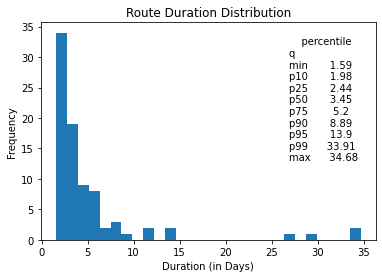

Mean Duration: 5.4 days


In [4]:
def get_percentiles(s, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [round(s.min(),2)] + [round(s.quantile(i), 2) for i in q] + [round(s.max(),2)]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

plt.hist(moodytown_davisfort_df.totalDurationDays, bins=max(round(moodytown_davisfort_df.shape[0]/3),5))
plt.title('Route Duration Distribution')
plt.ylabel('Frequency')
plt.xlabel('Duration (in Days)')
plt.figtext(0.7, 0.4, get_percentiles(moodytown_davisfort_df.totalDurationDays).to_string())
plt.show()
print(f'Mean Duration: {round(moodytown_davisfort_df.totalDurationDays.mean(),1)} days')

Notice the distribution has a long right tail. This is characteristic for many of the other shipment routes where most shipments fall into a tight range of duration times, with a few extreme cases that have much longer times, sometimes ten or more times greater than the median.

## Identify Faster Routes and Improve Performance with Path Finding

Neo4j has a robust family of [10+ algorithms for path finding](https://neo4j.com/docs/graph-data-science/current/algorithms/pathfinding/).  These algorithms can be used to explore, recommend, and optimize paths in supply chains.  To highlight just a few of these algorithms:

- [Dikstra’s Source-Target Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/dijkstra-source-target/) is a classic graph algorithm for finding the shortest path between two nodes

- [Yen's K-Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/yens/) finds a ranked list of top `k` shortest paths between two nodes

- [Delta-Stepping Single-Source Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/delta-single-source/) uses parallelized computation to find the shortest paths between a single source node and multiple target nodes

- [A* Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/astar/) is an extension of Dijkstra that uses heuristics to speed up computation and is particularly well-suited for paths between geospatial points


In this notebook we will focus on [Yen's K-Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/yens/) to provide multiple route recommendations.

Yen’s algorithm, along with most other neo4j Graph Data Science path finding algorithms, can be weighted with relationship properties to take variable costs associated with time, distance, and other operations into consideration.  In this case we will use the average effective minutes of the business processes.  This will allow us to find paths that minimize the approximate average duration, which we will refer to as the “fastest” paths. There are some statistical considerations to keep in mind when using averages this way. Depending on your use case you may also want to choose a different type of aggregate measure. I cover this in more detail in the appendix.  If you are considering using this type of solution in a production capacity I recommend reading it. For now though, the following steps provide a good starting point for path finding based on historical data.

### Create Graph Projection
The below Cypher projection aggregates parallel relationships and creates the average effective time relationship property. We will recreate the graph projection if it already exists.

In [5]:
def drop_graph_by_name(graph_name: str):
    if gds.graph.exists(graph_name).loc['exists']:
        gds.graph.get(graph_name).drop()

In [6]:
drop_graph_by_name('proj')
g, _ = gds.graph.project.cypher('proj',
    '''
   MATCH(n)
   WHERE n:EntryPoint 
       OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
   RETURN id(n) as id, labels(n) as labels
   '''
    ,
    '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type, avg(r.effectiveMinutes) AS averageEffectiveMinutes
    '''
)
_

nodeQuery            MATCH(n)\n   WHERE n:EntryPoint \n       OR n:...
relationshipQuery    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DEL...
graphName                                                         proj
nodeCount                                                         1422
relationshipCount                                                 2024
projectMillis                                                      110
Name: 0, dtype: object

### Path Finding
After you create the graph projection you can begin with path finding.  For our first example, let’s get the top 10 shortest paths going from Moodytown to Davisport.

In [7]:
source_airport_name = 'Moodytown'
target_airport_name = 'Davisfort'
source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
target_node_id = gds.find_node_id(['Destination'], {'name': target_airport_name})
yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id, k=10,
                                      relationshipWeightProperty='averageEffectiveMinutes')

In [8]:
def get_airport_names(p):
    return ' -> '.join(list(dict.fromkeys([node.get('name') for node in p.nodes])))
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
yen_df['totalCostFormatted'] = ds_utils.minutes_to_duration(yen_df.totalCost)
top_path_df = yen_df[['airportPath', 'totalCostFormatted']].rename(columns={'totalCostFormatted':'approximateAvgTime'})
top_path_df

,airportPath,approximateAvgTime
0,Moodytown -> Davisfort,"02 days, 14 hrs, 23 min"
1,Moodytown -> Michaelstad -> Davisfort,"03 days, 01 hrs, 29 min"
2,Moodytown -> Wandaborough -> Davisfort,"03 days, 04 hrs, 28 min"
3,Moodytown -> Matthewport -> Davisfort,"03 days, 04 hrs, 57 min"
4,Moodytown -> Bryanside -> Davisfort,"03 days, 06 hrs, 16 min"
5,Moodytown -> Shanefort -> Davisfort,"03 days, 07 hrs, 58 min"
6,Moodytown -> Langborough -> Davisfort,"03 days, 09 hrs, 01 min"
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,"03 days, 12 hrs, 24 min"
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,"03 days, 14 hrs, 07 min"
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,"03 days, 15 hrs, 54 min"


Notice that the best path is a direct flight from Moodytown to Davisport. By nature of the freight forwarding model, we don’t have direct deliveries in the dataset.  We will see in part 2 of this analysis, which gets into freight forwarding combinations, that there are opportunities for reducing total costs by taking longer routes through connecting airports which motivates the use of multi-step paths despite them taking longer on average.

Let's compare the above paths to those historically taken in the dataset.  We will do this by merging the above results to actual historic paths which we can pull with Cypher.  Below is the resulting dataframe.

In [9]:
top_path_df.merge(ds_utils.historic_path_counts(gds, source_airport_id, target_airport_id), on='airportPath', 
                  how='outer')

,airportPath,approximateAvgTime,historicPathCount,historicAvgCost,historicCostStd,historicCosts
0,Moodytown -> Davisfort,"02 days, 14 hrs, 23 min",NaN,NaN,NaN,NaN
1,Moodytown -> Michaelstad -> Davisfort,"03 days, 01 hrs, 29 min",48.0,"02 days, 21 hrs, 57 min","01 days, 04 hrs, 49 min","[02days-04hrs-15min, 02days-01hrs-13min, 02day..."
2,Moodytown -> Wandaborough -> Davisfort,"03 days, 04 hrs, 28 min",1.0,"03 days, 11 hrs, 27 min","00 days, 00 hrs, 00 min",[03days-11hrs-27min]
3,Moodytown -> Matthewport -> Davisfort,"03 days, 04 hrs, 57 min",NaN,NaN,NaN,NaN
4,Moodytown -> Bryanside -> Davisfort,"03 days, 06 hrs, 16 min",NaN,NaN,NaN,NaN
5,Moodytown -> Shanefort -> Davisfort,"03 days, 07 hrs, 58 min",5.0,"04 days, 00 hrs, 08 min","01 days, 10 hrs, 17 min","[05days-05hrs-22min, 02days-08hrs-19min, 04day..."
6,Moodytown -> Langborough -> Davisfort,"03 days, 09 hrs, 01 min",1.0,"02 days, 10 hrs, 34 min","00 days, 00 hrs, 00 min",[02days-10hrs-34min]
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,"03 days, 12 hrs, 24 min",NaN,NaN,NaN,NaN
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,"03 days, 14 hrs, 07 min",NaN,NaN,NaN,NaN
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,"03 days, 15 hrs, 54 min",NaN,NaN,NaN,NaN


Notice that the second best path through Michaelstad is by far the most frequently used route historically.  However, there still seem to be many routes that aren’t reflected in our shortest path recommendations.  For example, there are 11 instances going through Scottstown which isn’t even in the top 15 recommended paths, as well as 5 through Amandachester and 4 through Simonfurt.

### Improving Performance by Selecting New Routes
While Scotttown was heavily utilized historically, our application of path finding revealed multiple other faster options. We are already routing many flights through Michaelstad, so what if we routed the Scotttown flights through Wandaborough instead which has a very similar approximate average time to the Michaelstad path?

With a bit of arithmetic, we can estimate that by switching the Scottstown flights to go through Wondaburough instead, __*we could see an approx 40% decrease in average time which is rather significant*__.

To calculate this, it is important to note that the approximate average times from our Yen’s shortest paths and the actual historic average times won’t be exactly the same for a variety of reasons.  These include large variance in flight times and the fact that shortest paths tend to go through flight segment connections rather than proper TransferPoints (points where incoming and outgoing legs connect in the graph schema triggering another freight reception process).  Nevertheless, the shortest path approximate average times and historic average times should be well correlated, and if we assume they are relatively proportional we can estimate differences in performance between different paths. For the above example, we can note that the Wondaburough connected path (#2) is only slightly longer than the Michaelstad connected path (#1) and that the average historic time of the Michaelstad connected path is under 60% that of the Scottstown connected path (#10). A bit of percentage calculations will allow you to reach the solution I came to above.

## Cleanup

In [10]:
# remove graph projection
drop_graph_by_name('proj')

## Appendix

### Note on Using Averages and Interpreting Results
In this notebook we used average times in our graph projection to find shortest paths, specifically the arithmetic mean of effective minutes.  The arithmetic mean can serve as a good summary measure for overall recommendation and analytics, but one must be careful not to fall into “flaw of average” assumptions while using it.  In the context of our problem, what this means is that while we approximate what average times will be over many shipments in our path finding recommendations, it is possible for individual shipment times to be shorter or much longer than the approximation averages. As such, the predicted average times should not be relied upon with low/zero tolerance for delays or early arrivals on an individual shipment-by-shipment basis.
Additionally, you may want to change the type of aggregate measure depending on your supply chain use case.  For example, if your performance is really sensitive to long delays but robust to otherwise smaller variances in times, you may consider using the 95th percentile, or similarly higher percentile of the distribution instead of the arithmetic mean.  On the other hand, if your data rarely has long delays and you would like to exclude them as outliers, using the median instead of the arithmetic mean can help with that.